In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


# 1. 文字前處理

In [3]:
udn = pd.read_csv("raw_data\merge_from_ofoct copy.csv")  # 匯資料
# 找出 boardID 欄位值為 'boardID' 的資料行索引
indices_to_drop = udn[udn['boardID'] == 'boardID'].index

# 刪除這些資料行
udn.drop(indices_to_drop, inplace=True)

# 顯示更新後的前三行數據
udn.head(3)
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/talk/p/255935216,2024-06-23 23:26:22,睡到一半被酸醒,有時候都會睡到半夜突然被右手臂酸醒，而且是從手臂酸到右腳然後又有一種尿急的感覺(完全沒有想尿...,talk,0,q00148,M,allen
1,2,Dcard,https://www.dcard.tw/f/talk/p/255935193,2024-06-23 23:14:11,在停車場正要離開時，被車子擋住會怎樣,在停車場繳完費正要離開時\n\n有車主因為懶得走路，把車子開到距離繳費機比較近的地方，再下車...,talk,1,NaN,F,國立臺灣藝術大學
2,3,Dcard,https://www.dcard.tw/f/talk/p/255933439,2024-06-23 15:40:44,請問大家願意花多少錢去蜜月（2人）呢？,Option #1: 30萬以下\nOption #2: 30-40萬\nOption #3...,talk,0,k9999303,M,一起看日出


In [4]:
print(udn['artDate'].dtype)

# 嘗試將 'artDate' 列轉換為日期格式
udn['artDate'] = pd.to_datetime(udn['artDate'], errors='coerce')

# 再次檢查是否有無效日期
print(udn['artDate'].isna().sum())

# 然後重新執行原來的代碼
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['boardID'].value_counts()}")


object
0
number of posts: 6012
date range: (Timestamp('2024-05-01 00:02:51'), Timestamp('2024-06-24 08:59:29'))
category: 
relationship    2234
mood            2160
talk            1618
Name: boardID, dtype: int64


## 1.1清理

In [5]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school
0,1,Dcard,https://www.dcard.tw/f/talk/p/255935216,2024-06-23 23:26:22,睡到一半被酸醒,有時候都會睡到半夜突然被右手臂酸醒而且是從手臂酸到右腳然後又有一種尿急的感覺完全沒有想尿尿整...,talk,0,q00148,M,allen
1,2,Dcard,https://www.dcard.tw/f/talk/p/255935193,2024-06-23 23:14:11,在停車場正要離開時被車子擋住會怎樣,在停車場繳完費正要離開時有車主因為懶得走路把車子開到距離繳費機比較近的地方再下車繳費但他剛好...,talk,1,NaN,F,國立臺灣藝術大學
2,3,Dcard,https://www.dcard.tw/f/talk/p/255933439,2024-06-23 15:40:44,請問大家願意花多少錢去蜜月人呢,萬以下萬萬萬以上,talk,0,k9999303,M,一起看日出


整合標題和內文成新欄位content

In [6]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "boardID"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,boardID
0,睡到一半被酸醒有時候都會睡到半夜突然被右手臂酸醒而且是從手臂酸到右腳然後又有一種尿急的感覺完...,https://www.dcard.tw/f/talk/p/255935216,talk
1,在停車場正要離開時被車子擋住會怎樣在停車場繳完費正要離開時有車主因為懶得走路把車子開到距離繳...,https://www.dcard.tw/f/talk/p/255935193,talk
2,請問大家願意花多少錢去蜜月人呢萬以下萬萬萬以上,https://www.dcard.tw/f/talk/p/255933439,talk
3,中山東門商圈廁所推薦不知道大家會不會在逛街的時候常常找不到廁所或是常常遇到很髒的廁所前幾天在...,https://www.dcard.tw/f/talk/p/255933530,talk
4,不喜歡機車約會我約會的時候都會認真打扮每次都花兩個小時化妝整理髮型所以真的很不喜歡坐機車尤其...,https://www.dcard.tw/f/talk/p/255933536,talk


In [7]:
print(f"total docs: {udn.shape[0]}")

total docs: 5897


## 1.2斷詞

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")

# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [10]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

Building prefix dict from c:\Users\a8184\OneDrive\桌面\作品\分類器01\dict\dict.txt.big ...
Dumping model to file cache C:\Users\a8184\AppData\Local\Temp\jieba.u5bd41fb04ae18e2b6ac8424ea2f38c8c.cache
Loading model cost 1.433 seconds.
Prefix dict has been built successfully.


,content,artUrl,boardID,words
0,睡到一半被酸醒有時候都會睡到半夜突然被右手臂酸醒而且是從手臂酸到右腳然後又有一種尿急的感覺完...,https://www.dcard.tw/f/talk/p/255935216,talk,一半 被酸醒 有時候 半夜 突然 手臂 酸醒 是從 手臂 酸到 右腳 一種 尿急 感覺 完全...
1,在停車場正要離開時被車子擋住會怎樣在停車場繳完費正要離開時有車主因為懶得走路把車子開到距離繳...,https://www.dcard.tw/f/talk/p/255935193,talk,停車場 正要 開時 車子 擋住 停車場 繳完費 正要 開時 車主 懶得 走路 車子 距離 繳...
2,請問大家願意花多少錢去蜜月人呢萬以下萬萬萬以上,https://www.dcard.tw/f/talk/p/255933439,talk,請問 願意 多少錢 蜜月 以下 萬萬 以上
3,中山東門商圈廁所推薦不知道大家會不會在逛街的時候常常找不到廁所或是常常遇到很髒的廁所前幾天在...,https://www.dcard.tw/f/talk/p/255933530,talk,中山 東門 商圈 廁所 推薦 知道 逛街 不到 廁所 遇到 很髒 廁所 幾天 中山 看到 有...
4,不喜歡機車約會我約會的時候都會認真打扮每次都花兩個小時化妝整理髮型所以真的很不喜歡坐機車尤其...,https://www.dcard.tw/f/talk/p/255933536,talk,喜歡 機車 約會 約會 認真 打扮 每次 兩個 小時 化妝 整理 髮型 真的 喜歡 機車 尤...


In [11]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['boardID'].value_counts()}")


total posts: 5897
category: 
relationship    2216
mood            2119
talk            1562
Name: boardID, dtype: int64


# 2. 訓練分類器

## 2.1 切分資料 7:3

In [12]:
data = udn
X = data["words"]
y = data["boardID"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

3431                 智障 網美 拜託 哪有 白癡 網美會 介紹 紅色 還套 濾鏡 阿是 智障
3301    死後才 想起 曾經 答應 一起 散步 首歌 去年 演唱會 阿尼對 爸爸 真情 告白 知道 聽...
5795                        美女 標配 美女 眼睛 比較 重要 鼻子 比較 重要 部分
3193    該不該 再給 一次 機會 曾經 工作 飯店 受到 不小 迫害 主管 刁難 針對 資料 辦公室...
4299    天蠍 男愛 吃醋 認識 一位 天蠍 之間 有點 曖昧 分享 一位 喜歡 旁聽 覺得 神秘 試...
Name: words, dtype: object
3431            mood
3301            mood
5795            talk
3193            mood
4299    relationship
Name: boardID, dtype: object


In [13]:
# 看一下各個資料集切分的比例
print(
    f"raw data percentage :\n{data['boardID'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
relationship    37.578430
mood            35.933526
talk            26.488045
Name: boardID, dtype: float64

train percentage :
relationship    38.114853
mood            35.909862
talk            25.975285
Name: boardID, dtype: float64

test percentage :
relationship    36.327684
mood            35.988701
talk            27.683616
Name: boardID, dtype: float64


## 2.2 轉DTM

In [14]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### 先用 LogisticRegression 建立分類器

In [15]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

LogisticRegression()

In [16]:
clf.classes_

array(['mood', 'relationship', 'talk'], dtype=object)

In [17]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        mood       0.61      0.63      0.62       637
relationship       0.74      0.80      0.77       643
        talk       0.66      0.56      0.61       490

    accuracy                           0.67      1770
   macro avg       0.67      0.66      0.67      1770
weighted avg       0.67      0.67      0.67      1770



### Cross-Vaiodation

In [18]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=500).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=3, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.04986787, 0.05736089, 0.06733751]),
 'score_time': array([0.02194095, 0.02194118, 0.02094483]),
 'test_f1_macro': array([0.65782584, 0.61919924, 0.63025076]),
 'test_precision_macro': array([0.66001772, 0.61998473, 0.63294794]),
 'test_recall_macro': array([0.65666784, 0.61854614, 0.62857266])}


In [19]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=3)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

        mood       0.59      0.62      0.60      1482
relationship       0.75      0.75      0.75      1573
        talk       0.57      0.54      0.56      1072

    accuracy                           0.65      4127
   macro avg       0.64      0.63      0.64      4127
weighted avg       0.65      0.65      0.65      4127



# 3 比較不同模型效果

In [20]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")
    
    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

now training: clf_logistic
              precision    recall  f1-score   support

        mood       0.60      0.62      0.61      1482
relationship       0.75      0.76      0.76      1573
        talk       0.59      0.55      0.57      1072

    accuracy                           0.66      4127
   macro avg       0.65      0.64      0.64      4127
weighted avg       0.65      0.66      0.65      4127

now training: clf_dtree
              precision    recall  f1-score   support

        mood       0.49      0.48      0.49      1482
relationship       0.65      0.64      0.64      1573
        talk       0.47      0.49      0.48      1072

    accuracy                           0.54      4127
   macro avg       0.54      0.54      0.54      4127
weighted avg       0.55      0.54      0.55      4127

now training: clf_svm
              precision    recall  f1-score   support

        mood       0.59      0.67      0.63      1482
relationship       0.76      0.76      0.76      1573
  

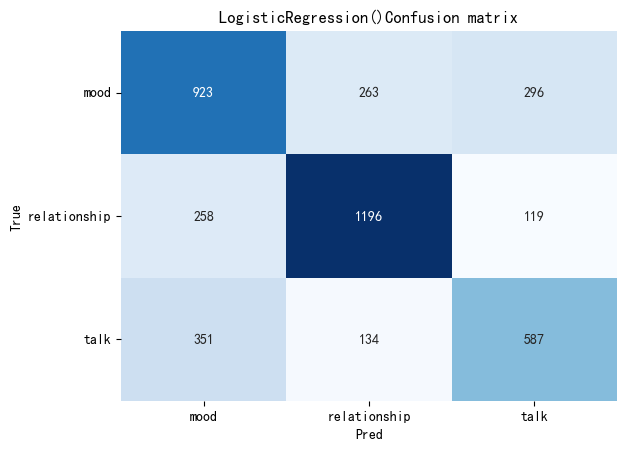

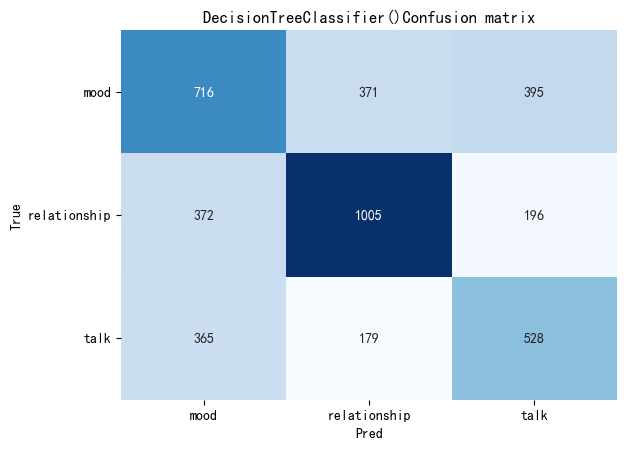

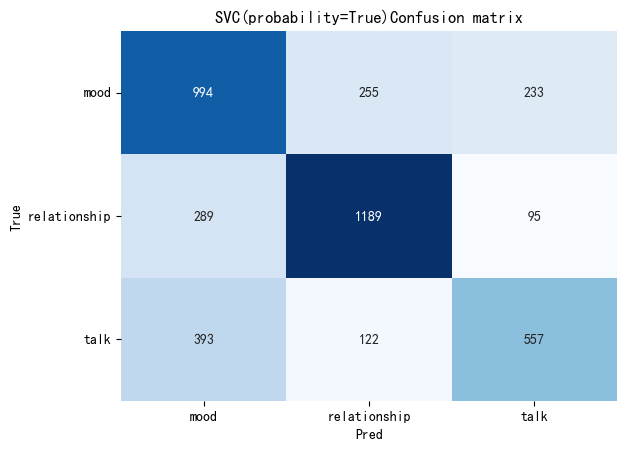

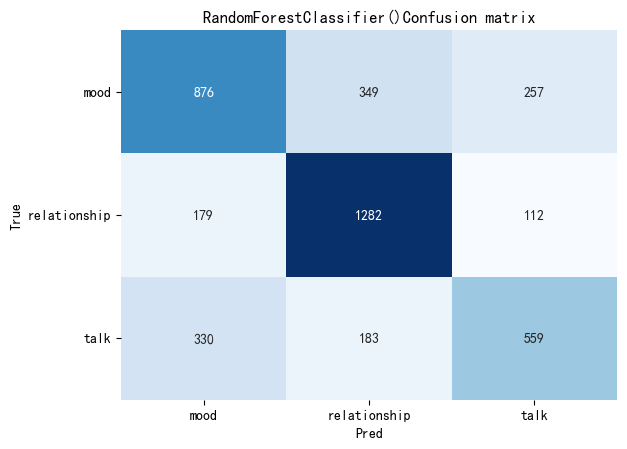

In [21]:
# 準備訓練資料
X = data["words"]
y = data["boardID"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [22]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        mood       0.62      0.58      0.60       637
relationship       0.68      0.85      0.75       643
        talk       0.68      0.51      0.58       490

    accuracy                           0.66      1770
   macro avg       0.66      0.65      0.64      1770
weighted avg       0.66      0.66      0.65      1770



# 4. 測試結果

In [49]:
doc = "今天和男友吵架並提了分手"
doc_list = getToken(doc)
combined_string = ' '.join(doc_list)
combined_string =[combined_string]
model_set['clf_svm'].predict(vectorizer.transform(combined_string).toarray())

array(['relationship'], dtype=object)

In [50]:
doc = "昨天晚上做夢，夢到自己中了一百萬"
doc_list = getToken(doc)
combined_string = ' '.join(doc_list)
combined_string =[combined_string]
model_set['clf_svm'].predict(vectorizer.transform(combined_string).toarray())

array(['talk'], dtype=object)

In [51]:
doc = "最近梅雨季，每天都下雨，我的心情也跟著憂鬱了起來"
doc_list = getToken(doc)
combined_string = ' '.join(doc_list)
combined_string =[combined_string]
model_set['clf_svm'].predict(vectorizer.transform(combined_string).toarray())

array(['mood'], dtype=object)

In [52]:
doc = input("輸入文章內容：")
doc_list = getToken(doc)
# model_set['clf_svm'].predict(vectorizer.transform(doc_list).toarray())
combined_string = ' '.join(doc_list)
combined_string =[combined_string]
model_set['clf_svm'].predict(vectorizer.transform(combined_string).toarray())

array(['relationship'], dtype=object)